<a href="https://colab.research.google.com/github/ryorinsama/AAAA/blob/main/AAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import numpy as np
import pandas as pd
# univariate multi-step lstm for the power usage dataset
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [146]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [148]:
# load dataset
dataset = pd.read_csv('drive/My Drive/Colab Notebooks/datanewnew.csv', header=0, index_col='Date', parse_dates=True)
values = dataset.values

In [149]:
# ensure all data is float
values = values.astype('float32')

In [150]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[3]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)   var1(t)
1        0.0        0.0  0.000000
2        0.0        0.0  0.000000
3        0.0        0.0  0.000000
4        0.0        0.0  0.000000
5        0.0        0.0  0.018144


In [151]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 2) (8760,) (8927, 1, 2) (8927,)


Epoch 1/50
274/274 - 4s - loss: 0.0282 - val_loss: 0.0111 - 4s/epoch - 15ms/step
Epoch 2/50
274/274 - 2s - loss: 0.0096 - val_loss: 0.0111 - 2s/epoch - 9ms/step
Epoch 3/50
274/274 - 3s - loss: 0.0096 - val_loss: 0.0111 - 3s/epoch - 11ms/step
Epoch 4/50
274/274 - 1s - loss: 0.0096 - val_loss: 0.0111 - 1s/epoch - 5ms/step
Epoch 5/50
274/274 - 1s - loss: 0.0096 - val_loss: 0.0111 - 1s/epoch - 5ms/step
Epoch 6/50
274/274 - 2s - loss: 0.0096 - val_loss: 0.0112 - 2s/epoch - 6ms/step
Epoch 7/50
274/274 - 1s - loss: 0.0096 - val_loss: 0.0112 - 1s/epoch - 4ms/step
Epoch 8/50
274/274 - 1s - loss: 0.0096 - val_loss: 0.0112 - 984ms/epoch - 4ms/step
Epoch 9/50
274/274 - 1s - loss: 0.0096 - val_loss: 0.0112 - 1s/epoch - 5ms/step
Epoch 10/50
274/274 - 1s - loss: 0.0096 - val_loss: 0.0112 - 1s/epoch - 5ms/step
Epoch 11/50
274/274 - 2s - loss: 0.0096 - val_loss: 0.0112 - 2s/epoch - 6ms/step
Epoch 12/50
274/274 - 1s - loss: 0.0096 - val_loss: 0.0112 - 1s/epoch - 5ms/step
Epoch 13/50
274/274 - 1s - loss:

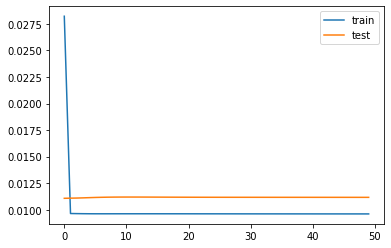

In [152]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [153]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

279/279 [==============================] - 1s 2ms/step


In [154]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 19.883
